In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss as logloss
from sklearn.metrics import accuracy_score 


%matplotlib inline
sns.set(style="white", color_codes=True)

# Print infomation about results
def cvs_test(clf, data_X, data_y, detail = False):
    cvs = -cross_val_score(clf, data_X, data_y, cv=5, n_jobs=-1, scoring='log_loss')
    if detail:
        for s in cvs:
            print("log loss = {}".format(s))
    print("log loss mean = {}".format(cvs.mean()))

    
def simple_test(clf, data_X, data_y, size = 0.2, seed = 0, ret = False):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=size, random_state=seed)
    clf.fit(X_train, y_train)    
    y_pred = clf.predict_proba(X_test)[:, 1]
    print("log loss = {}".format(logloss(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred.round(), normalize = False)
    print("Accuracy: {}".format(accuracy / y_test.shape[0]))
    print("Mislabled: {} out of {}".format(y_test.shape[0] - accuracy, y_test.shape[0]))    
    if ret:
        return y_pred


# Load data and roughly clean it, then sort as game date
df = pd.read_csv("data.csv")
df.drop(['game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name'], axis=1, inplace=True)
df.sort_values('game_date',  inplace=True)
mask = df['shot_made_flag'].isnull()

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


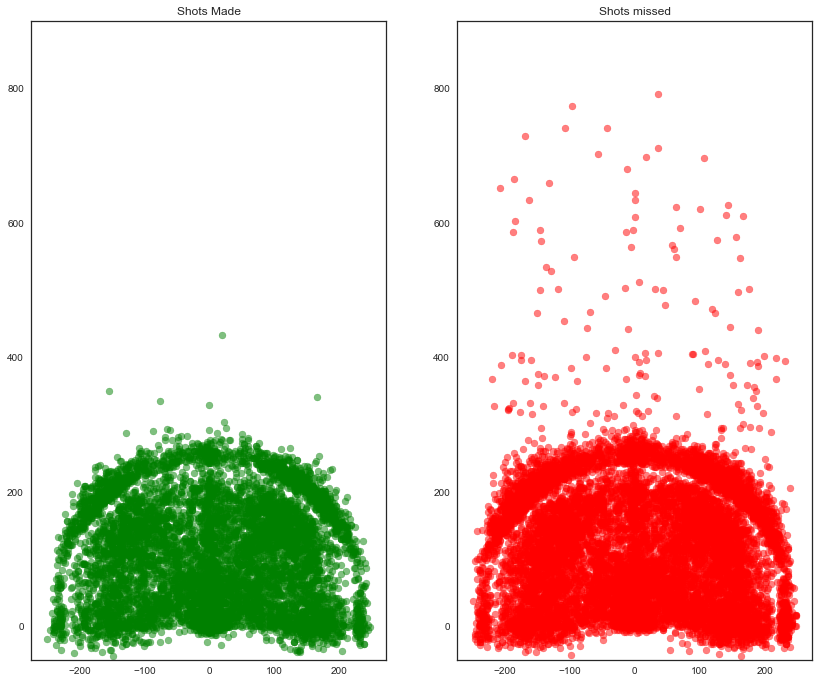

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


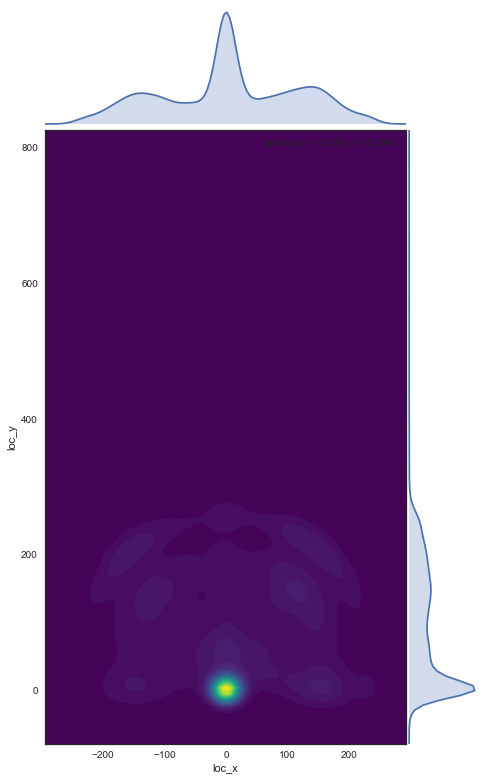

In [2]:
# Copy from ArjoonnSharma with slightly change.
# https://www.kaggle.com/arjoonn/kobe-bryant-shot-selection/preliminary-exploration

# Court visualization of misses and shots
court_scale = 7
plt.figure(figsize=(2 * court_scale, court_scale * 1.68))
# hit
plt.subplot(121)
h = df.loc[df.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha = 0.5)
plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
h = df.loc[df.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha = 0.5)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])
plt.show()
# XY plot
sns.jointplot(x="loc_x", y="loc_y", data=df, kind="kde", space=0,
              cmap=plt.cm.viridis, n_levels=50).fig.set_size_inches(court_scale,court_scale*1.68)

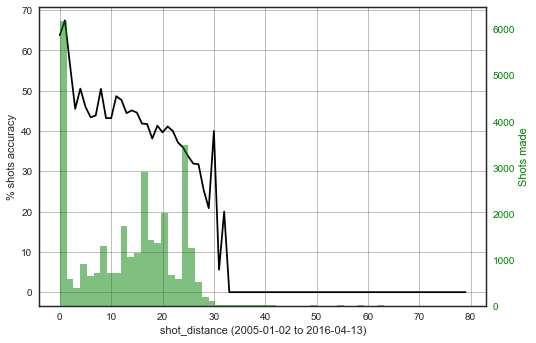

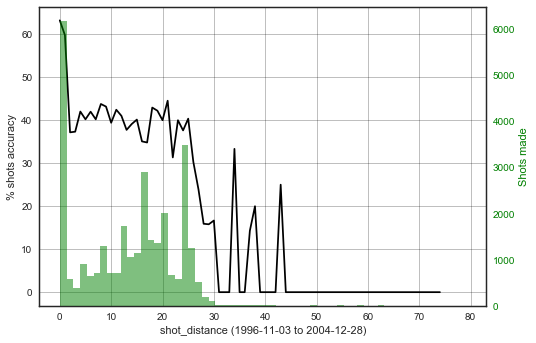

In [3]:
# Plot shot accuracy and number of shot made for seleted column during specific game date range
def plot_info(df, against, time_start = '1900-01-01', time_end = '2099-12-31'):
    start = df['game_date'].values.searchsorted([time_start])[0]
    end = df['game_date'].values.searchsorted([time_end])[0]
    data = df[start:end]
    ct = pd.crosstab(data.shot_made_flag, data[against]).apply(lambda row: 100 * row / row.sum())
    x, y = ct.columns, ct.values[1, :]
    fig, ax1 = plt.subplots()    
    ax1.plot(x, y, color='black')    
    ax1.set_xlabel(against + ' (' + data['game_date'].iloc[0] + ' to ' + data['game_date'].iloc[-1] + ')')
    ax1.set_ylabel('% shots accuracy')
    ax1.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.5)
    # Plot for right y axis
    ax2 = ax1.twinx()
    ax2.hist(df[against],color='green', bins = 60, alpha = 0.5)
    ax2.set_ylabel('Shots made', color='green')    
    for tl in ax2.get_yticklabels():
        tl.set_color('green')


plot_info(df, 'shot_distance', time_start = '2005-01-01')
plot_info(df, 'shot_distance', time_end = '2005-01-01')

In [4]:
# Clean data
#actiontypes = dict(df.action_type.value_counts())
#df['type'] = df.apply(lambda row: row['action_type'] if actiontypes[row['action_type']] > 20\
#                          else row['combined_shot_type'], axis=1)
#df.drop(['action_type', 'combined_shot_type'], axis=1, inplace=True)

df['away'] = df.matchup.str.contains('@').astype(int)
df.drop('matchup', axis=1, inplace=True)

df['shot_angle'] = np.arctan2(df['loc_y'], df['loc_x'])
df.drop(['loc_y', 'loc_x', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range'], axis=1, inplace=True)

df['time_remaining'] = df.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis = 1)
df.drop(['seconds_remaining', 'minutes_remaining'], axis=1, inplace=True)

df['shot_type'] = df['shot_type'].str.contains('2').astype(int)

df['season'] = LabelEncoder().fit_transform(df['season'])

df['game_year_month'] = LabelEncoder().fit_transform(df['game_date'].str[:-3])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 22901 to 22858
Data columns (total 15 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null int32
game_date             30697 non-null object
opponent              30697 non-null object
shot_id               30697 non-null int64
away                  30697 non-null int32
shot_angle            30697 non-null float64
time_remaining        30697 non-null int64
game_year_month       30697 non-null int64
dtypes: float64(2), int32(2), int64(7), object(4)
memory usage: 3.5+ MB


# to get the average shot pre game (around 20) run -> shot_count.values.mean().round()
shot_per_game = 20
shot_count = df.game_date.value_counts(sort=False).sort_index()
s1 = shot_count[shot_count > shot_per_game]

# The average accurace by game is around 44%, std is 14%
good_acc = 58
bad_acc = 30
ct = pd.crosstab(df.shot_made_flag, df['game_date']).apply(lambda raw: 100 * raw / raw.sum())
shot_acc=pd.Series(ct.values[1, :], ct.columns)
s_good = shot_acc[shot_acc > good_acc]
s_bad = shot_acc[shot_acc < bad_acc]

good_day = np.intersect1d(s1.index,s_good.index)
bad_day = np.intersect1d(s1.index,s_bad.index)

df['day'] = 0
df['day'] = df.apply(lambda row: 1 if row['game_date'] in good_day else\
                     -1 if row['game_date'] in bad_day else row['day'], axis = 1)

In [5]:
data = pd.DataFrame()

features=[ "action_type", "combined_shot_type", "opponent"]
for f in features:
    data = pd.concat([data, pd.get_dummies(df[f], prefix=f).astype(int)], axis=1)

appends = ["away", "playoffs", "period", "time_remaining", "shot_distance", "shot_angle", "game_year_month"]
for append in appends:
    data = pd.concat([data, df[append]], axis=1)

data.info()

X = data[~mask]
y = df.shot_made_flag[~mask]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 22901 to 22858
Columns: 103 entries, action_type_Alley Oop Dunk Shot to game_year_month
dtypes: float64(1), int32(97), int64(5)
memory usage: 13.0 MB


In [7]:
from xgboost.sklearn import XGBClassifier

print("-" * 10 + "XGBClassifier" + "-" * 10)
clf_xgb = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=500, subsample=0.6, colsample_bytree=0.6, seed=1234)
simple_test(clf_xgb, X, y)

----------XGBClassifier----------
log loss = 0.5950758835619699
Accuracy: 0.6821011673151751
Mislabled: 1634 out of 5140


features=["away", "period", "playoffs", "shot_type", "shot_zone_area", "shot_zone_basic","opponent", "distance", "minutes_remaining", "game_date",  "last_moments"]
          
----------XGBClassifier----------
50
log loss mean = 0.6470958101073359
100
log loss mean = 0.6270942393509178
200
log loss mean = 0.6143558179099733
300
log loss mean = 0.6120110835978058
400
log loss mean = 0.611816617866191
500
log loss mean = 0.6120377068553442
600
log loss mean = 0.6123119432968523
700
log loss mean = 0.6125981668100677
800
log loss mean = 0.6129179481163125
900
log loss mean = 0.6133098183837377
1000
log loss mean = 0.6136383043666481


Test for depth -> 10
features=["away", "period", "playoffs", "shot_type", "shot_zone_area", "shot_zone_basic", "season", "shot_zone_range", "opponent", "distance", "minutes_remaining", "last_moments"]

----------XGBClassifier----------
3
log loss = 0.6095695291656696
Mislabled: 1640 out of 5140
4
log loss = 0.6062992376706595
Mislabled: 1638 out of 5140
5
log loss = 0.6042685809382147
Mislabled: 1635 out of 5140
6
log loss = 0.6026768355373047
Mislabled: 1629 out of 5140
7
log loss = 0.6011863248357513
Mislabled: 1633 out of 5140
8
log loss = 0.6004780184883436
Mislabled: 1633 out of 5140
9
log loss = 0.5998282844019539
Mislabled: 1635 out of 5140
10
log loss = 0.599678254264483
Mislabled: 1632 out of 5140
11
log loss = 0.5998038472114892
Mislabled: 1636 out of 5140
12
log loss = 0.60024098467937
Mislabled: 1642 out of 5140
13
log loss = 0.6005725089312035
Mislabled: 1637 out of 5140
14
log loss = 0.6018256584914394
Mislabled: 1647 out of 5140

----------XGBClassifier----------
log loss = 0.5993085104587998
Mislabled: 1629 out of 5140

In [ ]:
print("-" * 10 + "RandomForestClassifier" + "-" * 10)
clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=10, random_state=1234)

simple_test(clf_rf, X, y)

In [ ]:
target_x = data[mask]
clf_xgb.fit(X, y)

target_y = clf_xgb.predict_proba(target_x)[:,1]
target_id = df[mask]["shot_id"]
submission = pd.DataFrame({"shot_id":target_id, "shot_made_flag":target_y})
submission.sort_values('shot_id',  inplace=True)
submission.to_csv("submissson28.csv",index=False)

print("Done!")